In [290]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import statsmodels.api as sm

Given that this problem involves multiple dataset, the process is divided in the following

**1.** Micro EDA- An Exploratory Data Analysis of just one dataset

**2.** Micro clustering

**3.** Data unification

**4.** Global clusters

**5.** Forecasting

**6.** Bonus problem

# Micro EDA

In [183]:
datasets = ['2014_05_purchases.xls','2014_06_purchases.xls','2014_07_purchases.xls',
'2014_08_purchases.xls','2014_09_purchases.xls','2014_10_purchases.xls','2014_11_purchases.xls','2014_12_purchases.xls',
'2015_01_purchases.xls','2015_02_purchases.xls','2015_03_purchases.xls','2015_05_purchases.xls','2015_06_purchases.xls','2015_07_purchases.xls',
'2015_08_purchases.xls','2015_09_purchases.xls','2015_10_purchases.xls','2015_11_purchases.xls','2015_12_purchases.xls','2016_01_purchases.xls','2016_02_purchases.xls',
'2016_03_purchases.xls','2016_04_purchases.xls','2016_05_purchases.xls','2016_06_purchases.xls','2016_07_purchases.xls','2016_08_purchases.xls','2016_09_purchases.xls',
'2016_10_purchases.xls','2016_11_purchases.xls','2016_12_purchases.xls','2017_01_purchases.xls','2017_02_purchases.xls','2017_03_purchases.xls','2017_04_purchases.xls',
'2017_05_purchases.xls','2017_06_purchases.xls','2017_07_purchases.xls','2017_08_purchases.xls','2017_09_purchases.xls','2017_10_purchases.xls','2017_11_purchases.xls',
'2018_01_purchases.xls']

Let's analyze just one month

In [3]:
data_2017_01 = pd.read_excel('./data/2017_01_purchases.xls')
data_2017_01.head()

TRANS DATE TRANS VAT DESC  ORIGINAL GROSS AMT ORIGINAL CUR  \
0 2017-01-03             VR               72.61          GBP   
1 2017-01-24             VR               85.51          GBP   
2 2017-02-01             VR               10.09          GBP   
3 2017-01-04             VR               20.00          GBP   
4 2017-01-05             VR               50.00          GBP   

   BILLING GROSS AMT BILLING CUR CODE       MERCHANT NAME       CARD NUMBER  \
0              72.61              GBP     shell kings 587  ************5770   
1              85.51              GBP  shell fiveways 387  ************1147   
2              10.09              GBP  shell fiveways 387  ************1147   
3              20.00              GBP  mibsons service st  ************5804   
4              50.00              GBP  malthurst petroleu  ************5804   

  TRANS CAC CODE 1 TRANS CAC DESC 1 TRANS CAC CODE 2         TRANS CAC DESC 2  \
0             K020     Vehicle Fuel            RV12N     African-Caribbean DC   
1             K020     Vehicle Fuel            RV1K2  Elders Group - Ladywood   
2             K020     Vehicle Fuel            RV1K2  Elders Group - Ladywood   
3             K020     Vehicle Fuel            RVA12     Enablement Tyburn Rd   
4             K020     Vehicle Fuel            RVA12     Enablement Tyburn Rd   

  TRANS CAC CODE 3          Directorate  
0              A00  Adult & Communities  
1              A00  Adult & Communities  
2              A00  Adult & Communities  
3              A00  Adult & Communities  
4              A00  Adult & Communities

In [4]:
data_2017_01['card_number'] = data_2017_01['CARD NUMBER'].apply(lambda x: x.replace('*', ''))
data_2017_01['card_number'] = pd.to_numeric(data_2017_01['card_number'])
data_2017_01['Directorate'] = data_2017_01['Directorate'].apply(lambda x: x.replace(' ', '')).str.lower()

In [5]:
data_2017_01.columns

Index(['TRANS DATE', 'TRANS VAT DESC', 'ORIGINAL GROSS AMT', 'ORIGINAL CUR',
       'BILLING GROSS AMT', 'BILLING CUR CODE', 'MERCHANT NAME', 'CARD NUMBER',
       'TRANS CAC CODE 1', 'TRANS CAC DESC 1', 'TRANS CAC CODE 2',
       'TRANS CAC DESC 2', 'TRANS CAC CODE 3', 'Directorate', 'card_number'],
      dtype='object')

In [6]:
data_2017_01['Directorate'].drop_duplicates()

0        adult&communities
247                 adults
252     corporateresources
496                  cyp&f
998           cyp&fschools
4007           development
4066         localservices
Name: Directorate, dtype: object

With a quick EDA, we can see that there are some anomalies. Although simple for the detection of anomalies, we can do a better process for the detection of the anomalies

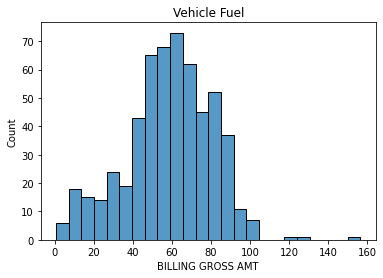

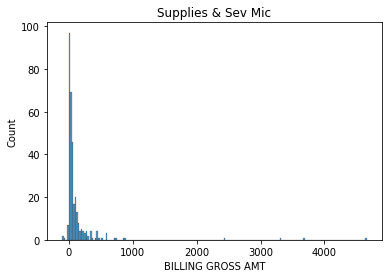

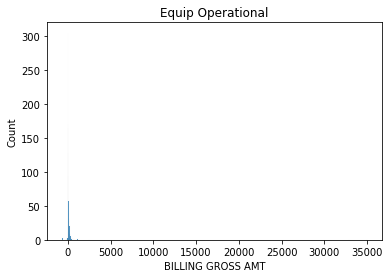

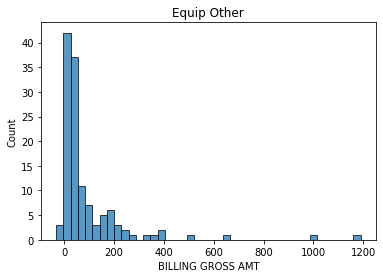

In [7]:
for transactions in data_2017_01['TRANS CAC DESC 1'].drop_duplicates()[:4]:
    fig, ax = plt.subplots()
    sns.histplot(data_2017_01.loc[data_2017_01['TRANS CAC DESC 1'] == transactions],x='BILLING GROSS AMT').set_title(transactions)
    plt.show()

Based on these histograms we found some anomalies, specially in the supplies and services and equip operational. Let's plot it in clusters so we can have a better  visualization

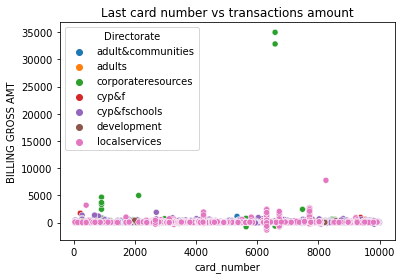

In [8]:
#plt.scatter(data_2017_01['card_number'], data_2017_01['BILLING GROSS AMT'], alpha=.2, label='TRANS CAC DESC 1')
sns.scatterplot(data=data_2017_01, x="card_number", y="BILLING GROSS AMT", hue="Directorate").set_title('Last card number vs transactions amount')
plt.show()

More useful than he other and we can say that corporate resources has at least two anomalies while local services has only one in the eyesight, but more can be done. First, let's join the data

Since this is a 1D data with all the rest of the features are factors or datetimes, instead of clusters we can use IQR outlier list and the three sigma rule

In [9]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [10]:
global_lowerbound,global_upperbound = outlier_treatment(data_2017_01['BILLING GROSS AMT'])

In [11]:
data_2017_01['Outlier'] = (data_2017_01['BILLING GROSS AMT']>global_upperbound) | (data_2017_01['BILLING GROSS AMT']< global_lowerbound)

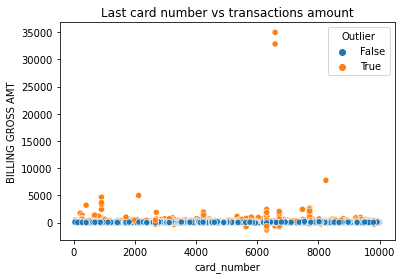

The outliers are the 11.50% of the cases


In [12]:
sns.scatterplot(data=data_2017_01, x="card_number", y="BILLING GROSS AMT", hue="Outlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_2017_01['Outlier'].sum()/data_2017_01['Outlier'].shape[0]*100))

Now, some areas areas have different scales than others, thus if I buy a car even its first monthly pay can be considered as an outlier if I group it with the groceries shopping costs. To reduce the number of outliers let's make a local outlier detection by directorate and type of purchase

In [13]:
def get_local_outliers(row, df, column):
    try:
        lower, upper = outlier_treatment(df.loc[df[column]==row[column]]['ORIGINAL GROSS AMT'])
        return (row['ORIGINAL GROSS AMT']>upper) | (row['ORIGINAL GROSS AMT']< lower)
    except:
        #print(row)
        return False

In [14]:
data_2017_01['IsDirectorateOutlier']=data_2017_01.apply(lambda x: get_local_outliers(x,data_2017_01,'Directorate'),axis=1)

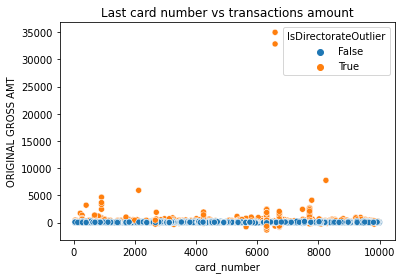

The outliers are the 10.92% of the cases


In [15]:
sns.scatterplot(data=data_2017_01, x="card_number", y="ORIGINAL GROSS AMT", hue="IsDirectorateOutlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_2017_01['IsDirectorateOutlier'].sum()/data_2017_01.shape[0]*100))

It is a .58% of difference, let's try with a more refined category

In [16]:
data_2017_01['IsAreaOutlier']=data_2017_01.apply(lambda x: get_local_outliers(x,data_2017_01,'TRANS CAC DESC 1'),axis=1)

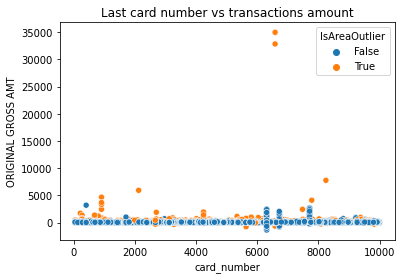

The outliers are the 7.81% of the cases


In [17]:
sns.scatterplot(data=data_2017_01, x="card_number", y="ORIGINAL GROSS AMT", hue="IsAreaOutlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_2017_01['IsAreaOutlier'].sum()/data_2017_01.shape[0]*100))

Now this make more sense. 7.81 is still a high number yet it is a more accurate way of classifying outliers

In [18]:
data_2017_01['IsCardOutlier']=data_2017_01.apply(lambda x: get_local_outliers(x,data_2017_01,'card_number'),axis=1)

Finally, as an experiment, we will go granular and go for the card number

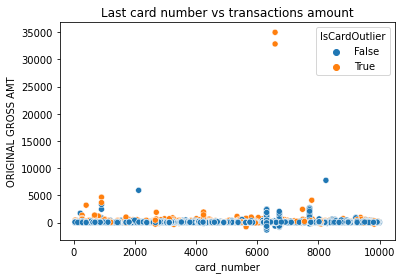

The outliers are the 9.18% of the cases


In [19]:
sns.scatterplot(data=data_2017_01, x="card_number", y="ORIGINAL GROSS AMT", hue="IsCardOutlier").set_title('Last card number vs transactions amount')
plt.show()
print('The outliers are the {:.2f}% of the cases'.format(data_2017_01['IsCardOutlier'].sum()/data_2017_01.shape[0]*100))

For the global analysis we are going to work with the area analysis since it is much better at getting outliers.

## Data unification

Let's see the columns

In [184]:
data_columns = ['TRANS DATE','ORIGINAL GROSS AMT','CARD NUMBER','TRANS CAC DESC 1','Directorate']
data_consolidated = pd.DataFrame(columns = data_columns)
#Critical columns 
for element in datasets:
    data = pd.read_excel('./data/'+element)
    data_consolidated = data_consolidated.append(data[data_columns])
    pass
print(data_columns)

['TRANS DATE', 'ORIGINAL GROSS AMT', 'CARD NUMBER', 'TRANS CAC DESC 1', 'Directorate']


In [185]:
data_consolidated.shape

(183219, 5)

In [186]:
data_consolidated = data_consolidated.dropna()
data_consolidated['Directorate'] = data_consolidated['Directorate'].apply(lambda x: x.replace(' ', '')).str.lower()

In [187]:
data_consolidated['Directorate'].replace({"adults&communities":"adult&communities"},inplace=True)
data_consolidated['Directorate'].replace({"adults&comms":"adult&communities"},inplace=True)
data_consolidated['Directorate'].replace({"cyo&f":"cyp&f"},inplace=True)

In [188]:

data_consolidated['card_number'] = data_consolidated['CARD NUMBER'].apply(lambda x: x.replace('*', ''))
data_consolidated['card_number'] = pd.to_numeric(data_consolidated['card_number'])

In [189]:
data_consolidated['Directorate'].drop_duplicates()

0              adult&communities
261           corporateresources
526                        cyp&f
1153                cyp&fschools
3532                 development
3682               localservices
209         corporateprocurement
441                       adults
0       adultsocialcareandhealth
Name: Directorate, dtype: object

Once the data is consolidated let's do the the anomaly detection

In [190]:
def get_upper_outliers(row, df, column):
    lower, upper = outlier_treatment(df.loc[df[column]==row[column]]['ORIGINAL GROSS AMT'])
    return upper

def get_lower_outliers(row, df, column):
    lower, upper = outlier_treatment(df.loc[df[column]==row[column]]['ORIGINAL GROSS AMT'])
    return lower

In [191]:
types_purchases = data_consolidated['TRANS CAC DESC 1'].drop_duplicates().values
#Creating a dataframe for as a pseudo dictionary
df_areas_outliers = pd.DataFrame(columns = ['TRANS CAC DESC 1'], data = types_purchases)
df_areas_outliers['upper_outlier']=df_areas_outliers.apply(lambda x: get_upper_outliers(x,data_consolidated,'TRANS CAC DESC 1'),axis=1)
df_areas_outliers['lower_outlier']=df_areas_outliers.apply(lambda x: get_lower_outliers(x,data_consolidated,'TRANS CAC DESC 1'),axis=1)


In [192]:
df_areas_outliers.head()
df_areas_outliers.sort_values(by=['upper_outlier'])

TRANS CAC DESC 1  upper_outlier  lower_outlier
113  Relocn&RecruitIncent        4.35000        4.35000
141                   Oil       11.98000       11.98000
142            Audit Fees       13.00000       13.00000
130       HRM CO Building       16.57000       16.57000
22    Vehicle OthrunCosts       20.55000       -6.25000
..                    ...            ...            ...
86   GOVEN'MNT DEPARTMNTS     1946.58625    -1113.64375
79    Transport Insurance     2369.70000    -1153.82000
94      SchGovBrds Clerks     2997.18750    -1757.11250
75    Other Third Parties     3851.32500    -1782.87500
24        Legal Fee Other     4905.00000    -2695.00000

[143 rows x 3 columns]

In [196]:
def get_local_outliers_area(row):
    try:
        return (row['ORIGINAL GROSS AMT']>=row['upper_outlier']) | (row['ORIGINAL GROSS AMT']<= row['lower_outlier'])
    except Exception as e:
        #print(row)
        #print(e)
        return False

In [197]:
data_consolidated_test = data_consolidated.copy()
data_consolidated_test = data_consolidated_test.head()
data_consolidated_test['IsAreaOutlier']=data_consolidated_test.apply(lambda x: get_local_outliers_area(x),axis=1) 
#data_consolidated_test = data_consolidated_test.merge(df_areas_outliers, left='TRANS CAC DESC 1', rsuffix='TRANS CAC DESC 1')
pd.merge(left=data_consolidated_test,right=df_areas_outliers, on='TRANS CAC DESC 1', how='left')
#data_consolidated_test

TRANS DATE  ORIGINAL GROSS AMT       CARD NUMBER TRANS CAC DESC 1  \
0 2014-07-01               59.99  ************5770     Vehicle Fuel   
1 2014-06-10               77.49  ************5770     Vehicle Fuel   
2 2014-06-27               48.66  ************8143     Vehicle Fuel   
3 2014-06-16                3.00  ************8143     Vehicle Fuel   
4 2014-07-01               53.17  ************8738     Vehicle Fuel   

         Directorate  card_number  IsAreaOutlier  upper_outlier  lower_outlier  
0  adult&communities         5770          False         112.43           2.59  
1  adult&communities         5770          False         112.43           2.59  
2  adult&communities         8143          False         112.43           2.59  
3  adult&communities         8143          False         112.43           2.59  
4  adult&communities         8738          False         112.43           2.59

In [198]:
data_consolidated_with_bounds = pd.merge(left=data_consolidated,right=df_areas_outliers, on='TRANS CAC DESC 1', how='left')

In [199]:
data_consolidated_with_bounds['IsOutlier'] = (data_consolidated_with_bounds['ORIGINAL GROSS AMT']>data_consolidated_with_bounds['upper_outlier']) | (data_consolidated_with_bounds['ORIGINAL GROSS AMT']<data_consolidated_with_bounds['lower_outlier'])

In [201]:
data_consolidated_with_bounds.head()

TRANS DATE  ORIGINAL GROSS AMT       CARD NUMBER TRANS CAC DESC 1  \
0 2014-07-01               59.99  ************5770     Vehicle Fuel   
1 2014-06-10               77.49  ************5770     Vehicle Fuel   
2 2014-06-27               48.66  ************8143     Vehicle Fuel   
3 2014-06-16                3.00  ************8143     Vehicle Fuel   
4 2014-07-01               53.17  ************8738     Vehicle Fuel   

         Directorate  card_number  upper_outlier  lower_outlier  IsOutlier  
0  adult&communities         5770         112.43           2.59      False  
1  adult&communities         5770         112.43           2.59      False  
2  adult&communities         8143         112.43           2.59      False  
3  adult&communities         8143         112.43           2.59      False  
4  adult&communities         8738         112.43           2.59      False

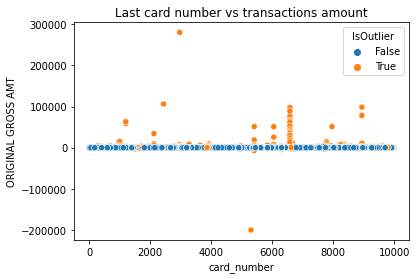

In [202]:
sns.scatterplot(data=data_consolidated_with_bounds, x="card_number", y="ORIGINAL GROSS AMT", hue="IsOutlier").set_title('Last card number vs transactions amount')
plt.show()

In [203]:
print('The outliers are the {:.2f}% of the cases'.format(data_consolidated_with_bounds['IsOutlier'].sum()/data_consolidated_with_bounds.shape[0]*100))

The outliers are the 8.28% of the cases


## Forecasting

Since the outliers are about 8.26% of the pursues we will have to remove them in order to do the time series

In [204]:
data_consolidated_cleared = data_consolidated_with_bounds.copy()
data_consolidated_cleared = data_consolidated_cleared.loc[data_consolidated_cleared.IsOutlier == False]
data_consolidated_cleared.shape[0]

167271

Now that we cleared the data, is time to put the data in terms of mean for each month. Also, we can do an whole analysis of for category. In this case the **Directorate** is going to be analized

In [205]:
furniture = data_consolidated_cleared.groupby('TRANS DATE')['ORIGINAL GROSS AMT'].sum().reset_index()
furniture = furniture.set_index('TRANS DATE')

In [206]:
import datetime 

In [232]:
timed_data = data_consolidated_cleared[['TRANS DATE','ORIGINAL GROSS AMT']]
timed_data = timed_data.rename(columns={"TRANS DATE": "date", "ORIGINAL GROSS AMT": "purchase"})
timed_data.head()
timed_data_train = timed_data.loc[timed_data.date < datetime.datetime(2017,1,1)]
timed_data_train = timed_data_train.loc[timed_data.date > datetime.datetime(2014,5,31)]
#timed_data_train = timed_data.copy()

In [278]:
tst2 =  timed_data.groupby('date')['purchase'].sum().reset_index()
tst2 = tst2.set_index('date')
y_full = tst2['purchase'].resample('MS').mean()
y_full

date
2014-05-01      -18.955000
2014-06-01    15518.691724
2014-07-01     8886.603226
2014-08-01     5024.399032
2014-09-01     7894.681000
2014-10-01     7475.038387
2014-11-01     8631.080333
2014-12-01     8006.164839
2015-01-01     8010.635161
2015-02-01     8655.871429
2015-03-01     9604.395484
2015-04-01     1661.318000
2015-05-01     5548.553548
2015-06-01     7818.554333
2015-07-01     6132.836129
2015-08-01     2937.412581
2015-09-01     6898.212333
2015-10-01     6427.380645
2015-11-01     7658.329667
2015-12-01     5188.998710
2016-01-01     7536.516129
2016-02-01    11948.490000
2016-03-01     9389.356129
2016-04-01    13686.700333
2016-05-01    15076.380323
2016-06-01    18793.309333
2016-07-01    15575.645484
2016-08-01    16623.393548
2016-09-01    19852.596333
2016-10-01    14884.701935
2016-11-01    15401.056000
2016-12-01     8327.167419
2017-01-01    11035.224516
2017-02-01    10428.189643
2017-03-01    16468.961935
2017-04-01    14389.427333
2017-05-01    19171.864

In [233]:
tst = timed_data_train.groupby('date')['purchase'].sum().reset_index()
tst = tst.set_index('date')
y2 = tst['purchase'].resample('MS').mean()
y2

date
2014-06-01    15518.691724
2014-07-01     8886.603226
2014-08-01     5024.399032
2014-09-01     7894.681000
2014-10-01     7475.038387
2014-11-01     8631.080333
2014-12-01     8006.164839
2015-01-01     8010.635161
2015-02-01     8655.871429
2015-03-01     9604.395484
2015-04-01     1661.318000
2015-05-01     5548.553548
2015-06-01     7818.554333
2015-07-01     6132.836129
2015-08-01     2937.412581
2015-09-01     6898.212333
2015-10-01     6427.380645
2015-11-01     7658.329667
2015-12-01     5188.998710
2016-01-01     7536.516129
2016-02-01    11948.490000
2016-03-01     9389.356129
2016-04-01    13686.700333
2016-05-01    15076.380323
2016-06-01    18793.309333
2016-07-01    15575.645484
2016-08-01    16623.393548
2016-09-01    19852.596333
2016-10-01    14884.701935
2016-11-01    15401.056000
2016-12-01     8327.167419
Freq: MS, Name: purchase, dtype: float64

For this case, we are going to use Seasonal ARIMA since the amount of years that we have is not enough for a neural network

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        pass
    pass

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y2,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

Let's forecast the purchases for the year

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-02-28'), dynamic=False)
pred_ci = pred.conf_int()

Text(0.5, 1.0, 'Predicted purchases for the year 2017')

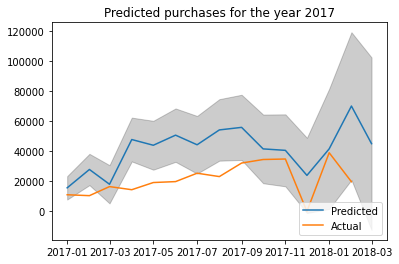

In [296]:
plt.plot(pred.predicted_mean)
plt.plot(y_full['2017':'2018'])
plt.legend(["Predicted", "Actual"], loc ="lower right")
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Predicted purchases for the year 2017')

Given the amount of datapoints it is expected that the model underperforms in the beggining but it detects the decrease in the purchases by septmber and the low in December. With a couple of years more of data. Its performance may increase

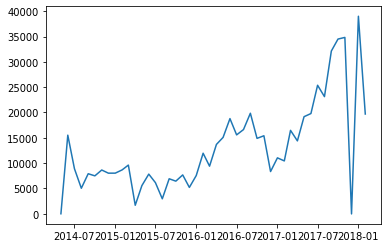

In [209]:
plt.plot(y2)

In [212]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

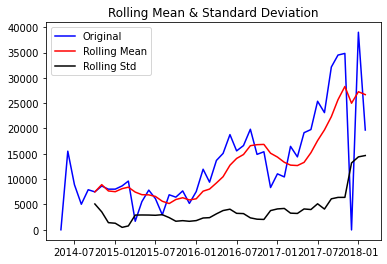

Results of Dickey-Fuller Test:
Test Statistic                 -0.772508
p-value                         0.827065
#Lags Used                      4.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [213]:
test_stationarity(y2)

d:\Globant\Task2\.venv\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


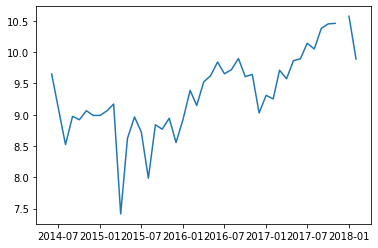

In [214]:
ts_log = np.log(y2)
plt.plot(ts_log)

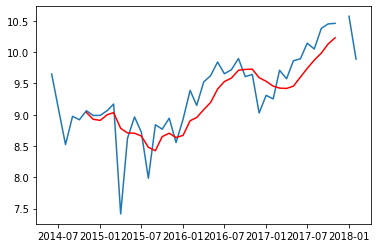

In [215]:
moving_avg = ts_log.rolling(6).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

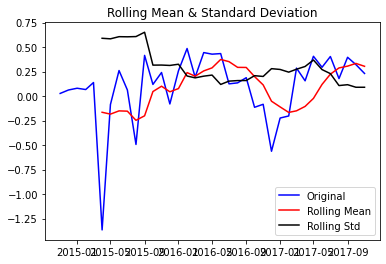

Results of Dickey-Fuller Test:
Test Statistic                 -3.401703
p-value                         0.010901
#Lags Used                      9.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


In [216]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(6)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

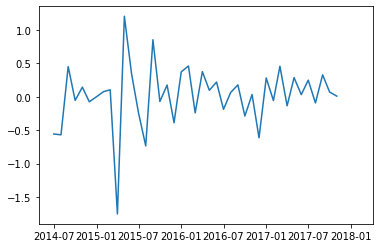

In [217]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [234]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [235]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [236]:
y2

date
2014-06-01    15518.691724
2014-07-01     8886.603226
2014-08-01     5024.399032
2014-09-01     7894.681000
2014-10-01     7475.038387
2014-11-01     8631.080333
2014-12-01     8006.164839
2015-01-01     8010.635161
2015-02-01     8655.871429
2015-03-01     9604.395484
2015-04-01     1661.318000
2015-05-01     5548.553548
2015-06-01     7818.554333
2015-07-01     6132.836129
2015-08-01     2937.412581
2015-09-01     6898.212333
2015-10-01     6427.380645
2015-11-01     7658.329667
2015-12-01     5188.998710
2016-01-01     7536.516129
2016-02-01    11948.490000
2016-03-01     9389.356129
2016-04-01    13686.700333
2016-05-01    15076.380323
2016-06-01    18793.309333
2016-07-01    15575.645484
2016-08-01    16623.393548
2016-09-01    19852.596333
2016-10-01    14884.701935
2016-11-01    15401.056000
2016-12-01     8327.167419
Freq: MS, Name: purchase, dtype: float64

In [237]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        pass
    pass

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:643.5694293326702
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:387.3722613960116
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:373.65165688222044
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:134.86308597494718
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:394.8952893441815
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:365.229865813089
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:147.41802138979588
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:125.13772316942399


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:598.6745681355688
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:358.16572244713626
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:348.1767706915436
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:107.63942303813666
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:398.6058392186143
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:357.01667881509326
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:146.62373187641373


d:\Globant\Task2\.venv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:104.73992695764336
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:553.5554394046725
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:327.85124349884194
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:331.345692764366
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:97.10135101924533
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:345.61677660466876
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:328.4798364235482
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:117.98002076803401
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:97.13033492149913
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:531.9561248728505
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:310.0172669480402
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:313.66528853621963
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:80.45553505515805
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:346.35172537244057
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:310.85499122195824
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:119.74295158114852
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:81.1598871381326
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:575.8703044714629
ARIM

In [238]:
mod = sm.tsa.statespace.SARIMAX(y2,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4400      3.528     -0.125      0.901      -7.355       6.475
ma.L1          0.3281      5.084      0.065      0.949      -9.636      10.292
ar.S.L12       2.0847      6.386      0.326      0.744     -10.432      14.601
sigma2      1.582e+07    1.3e-06   1.21e+13      0.000    1.58e+07    1.58e+07


In [241]:
results

In [287]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2018-02-28'), dynamic=False)
pred_ci = pred.conf_int()

In [288]:
pred.predicted_mean

2017-01-01    15641.747001
2017-02-01    27869.931315
2017-03-01    18014.358965
2017-04-01    47822.271150
2017-05-01    44008.391343
2017-06-01    50740.369901
2017-07-01    44329.658933
2017-08-01    54222.879512
2017-09-01    55927.038649
2017-10-01    41584.070902
2017-11-01    40610.731964
2017-12-01    23937.716596
2018-01-01    41607.130307
2018-02-01    70129.759225
2018-03-01    45063.309324
Freq: MS, Name: predicted_mean, dtype: float64

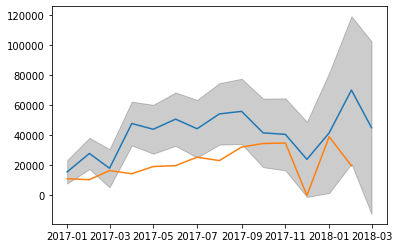

In [289]:
plt.plot(pred.predicted_mean)
plt.plot(y_full['2017':'2018'])
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

In [282]:
y_full['2017':]

date
2017-01-01    11035.224516
2017-02-01    10428.189643
2017-03-01    16468.961935
2017-04-01    14389.427333
2017-05-01    19171.864839
2017-06-01    19792.492333
2017-07-01    25383.788065
2017-08-01    23135.934194
2017-09-01    32150.699667
2017-10-01    34516.845161
2017-11-01    34841.225000
2017-12-01      -49.250000
2018-01-01    39027.566000
2018-02-01    19696.070000
Freq: MS, Name: purchase, dtype: float64

In [273]:
y_full[2017:]

Series([], Freq: MS, Name: purchase, dtype: float64)

<AxesSubplot:xlabel='date'>

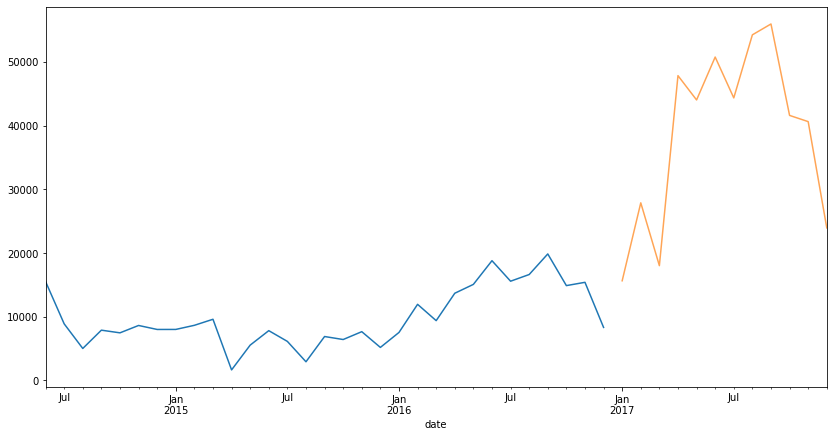

In [269]:
ax = y2['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

In [270]:
pred_ci

lower purchase  upper purchase
2017-01-01     7845.971065    23437.522937
2017-02-01    17443.690004    38296.172627
2017-03-01     5282.456358    30746.261573
2017-04-01    33225.814362    62418.727937
2017-05-01    27727.172169    60289.610516
2017-06-01    32946.294349    68534.445454
2017-07-01    25136.251108    63523.066759
2017-08-01    33727.668681    74718.090344
2017-09-01    34206.991118    77647.086181
2017-10-01    18705.048929    64463.092876
2017-11-01    16628.518172    64592.945755
2017-12-01    -1099.058363    48974.491554

No handles with labels found to put in legend.


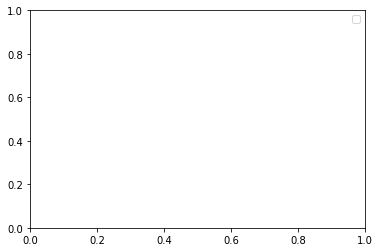

In [271]:
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

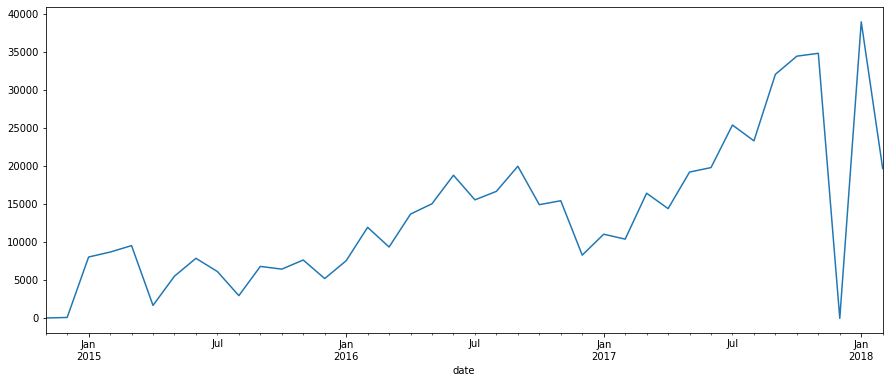

In [178]:
y2.plot(figsize=(15, 6))
plt.show()

## Train zone, delete later

In [102]:
df = pd.read_excel("data/test-data.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [104]:
furniture['Order Date'].min(), furniture['Order Date'].max()
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

d:\Globant\Task2\.venv\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Order Date    0
Sales         0
dtype: int64

In [106]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

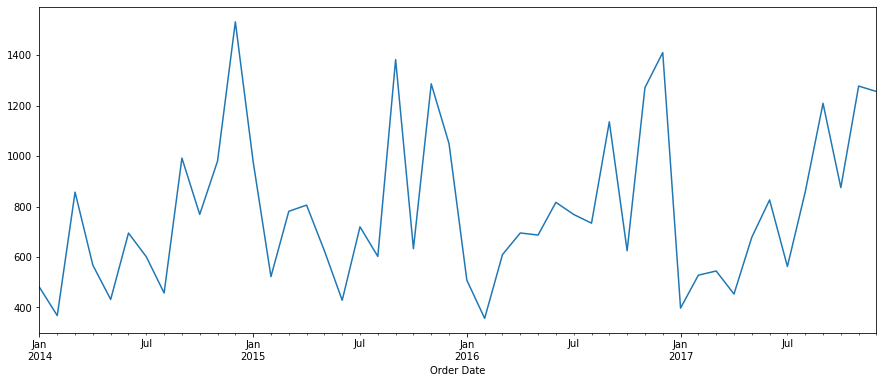

In [125]:
furniture.head()
y = furniture['Sales'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

In [128]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            print(e)

name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined
name 'sm' is not defined


In [99]:
data_consolidated_cleared
#precip_2003_2013_daily = data_consolidated_cleared.resample('M').mean()

TRANS DATE  ORIGINAL GROSS AMT       CARD NUMBER   TRANS CAC DESC 1  \
0      2015-01-08               52.84  ************5770       Vehicle Fuel   
1      2015-01-21               10.00  ************5770       Vehicle Fuel   
2      2015-01-22               20.01  ************5770       Vehicle Fuel   
3      2015-01-23               57.96  ************5770       Vehicle Fuel   
4      2015-01-07               60.50  ************8143       Vehicle Fuel   
...           ...                 ...               ...                ...   
150596 2018-01-10               63.83  ************4599       Vehicle Fuel   
150597 2018-02-02               34.64  ************4599       Vehicle Fuel   
150598 2018-01-24               48.01  ************2150       Vehicle Fuel   
150599 2018-01-13               20.55  ************8673  Equip Operational   
150600 2018-01-05               30.00  ************8673  Equip Operational   

              Directorate  card_number  upper_outlier  lower_outlier  \
0       adult&communities         5770        110.550          2.470   
1       adult&communities         5770        110.550          2.470   
2       adult&communities         5770        110.550          2.470   
3       adult&communities         5770        110.550          2.470   
4       adult&communities         8143        110.550          2.470   
...                   ...          ...            ...            ...   
150596      localservices         4599        110.550          2.470   
150597      localservices         4599        110.550          2.470   
150598      localservices         2150        110.550          2.470   
150599      localservices         8673        173.355        -85.845   
150600      localservices         8673        173.355        -85.845   

        IsOutlier  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
150596      False  
150597      False  
150598      False  
150599      False  
150600      False  

[138161 rows x 9 columns]

In [97]:
furniture.head()

ORIGINAL GROSS AMT
TRANS DATE                    
2014-11-25             -143.90
2014-11-29              146.66
2014-12-11              120.66
2014-12-18               30.10
2015-01-01               58.03

In [94]:
#y = furniture['TRANS DATE'].resample('MS').mean()
y =  furniture.resample('M', on='TRANS DATE').mean()

KeyError: 'The grouper name TRANS DATE is not found'

In [83]:
furniture

TRANS DATE  ORIGINAL GROSS AMT
0    2014-11-25             -143.90
1    2014-11-29              146.66
2    2014-12-11              120.66
3    2014-12-18               30.10
4    2015-01-01               58.03
...         ...                 ...
1077 2018-02-01            56411.54
1078 2018-02-02            29103.92
1079 2018-02-03             1068.12
1080 2018-02-04             2055.59
1081 2018-02-05             9682.77

[1082 rows x 2 columns]

In [81]:
data_consolidated_cleared.columns

Index(['TRANS DATE', 'ORIGINAL GROSS AMT', 'CARD NUMBER', 'TRANS CAC DESC 1',
       'Directorate', 'card_number', 'upper_outlier', 'lower_outlier',
       'IsOutlier'],
      dtype='object')

In [17]:
X=data_2017_01[['ORIGINAL GROSS AMT','card_number']].values
#X
#X_train = np.r_[X + 2, X - 2]
#X_train.shape

In [18]:
from sklearn import svm
X_test = 0.3 * np.random.randn(100, 2)
X_test.shape

(100, 2)

In [19]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X)

OneClassSVM(gamma=0.1, nu=0.1)

In [20]:
X_test = data_consolidated[['ORIGINAL GROSS AMT','card_number']]
y_pred_test = clf.predict(X_test)

In [21]:
y_pred_test

array([-1, -1, -1, ..., -1,  1, -1], dtype=int64)

In [22]:
data_consolidated['predicted']=y_pred_test
data_consolidated['predicted'].drop_duplicates()

0    -1
20    1
Name: predicted, dtype: int64

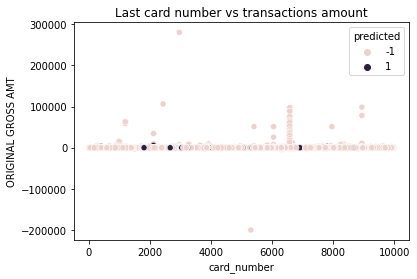

In [23]:
sns.scatterplot(data=data_consolidated, x="card_number", y="ORIGINAL GROSS AMT", hue="predicted").set_title('Last card number vs transactions amount')
plt.show()

In [143]:
(data_consolidated['Directorate'].value_counts()/data_consolidated['Directorate'].count())*100

CYP&F SCHOOLS                   47.726669
Local Services                  23.288035
CYP&F                           12.740870
Corporate Resources              6.710505
Adult & Communities              6.708515
DEVELOPMENT                      1.753769
Adult Social Care and Health     0.374244
CYP&F                            0.242197
CYP&F Schools                    0.227598
CYP&F                            0.084271
CYO&F                            0.061710
Development                      0.025879
Local services                   0.018579
Adults                           0.015925
Adults & Comms                   0.011944
Adults & Communities             0.006636
Corporate Procurement            0.001991
                                 0.000664
Name: Directorate, dtype: float64

In [72]:
from sklearn.svm import OneClassSVM
X = np.array([[0], [0.44], [0.45], [0.46], [1]])
clf = OneClassSVM(gamma='auto').fit(X)
clf.predict(X)
clf.score_samples(X)

array([1.77987316, 2.05479873, 2.05560497, 2.05615569, 1.73328509])

In [83]:
np.array([[0], [0.44], [0.45], [0.46], [1]])

array([[0.  ],
       [0.44],
       [0.45],
       [0.46],
       [1.  ]])

In [84]:
data_2017_01['ORIGINAL GROSS AMT'].values.reshape(-1, 1)

array([[72.61],
       [85.51],
       [10.09],
       ...,
       [17.98],
       [20.69],
       [26.99]])

In [ ]:
sns.scatterplot(data=data_consolidated, x="card_number", y="ORIGINAL GROSS AMT", hue="Directorate").set_title('Last card number vs transactions amount')
plt.show()

In [85]:
X = data_2017_01['ORIGINAL GROSS AMT'].values.reshape(-1, 1)
clf = OneClassSVM(gamma='auto').fit(X)
clf.predict(X)
clf.score_samples(X)

array([23.26173615, 22.91460022, 23.27045982, ..., 23.27027016,
       23.27030632, 23.27025284])

In [ ]:
data_2017_01.loc[data_2017_01['ORIGINAL GROSS AMT']!= data_2017_01['BILLING GROSS AMT']]

d:\Globant\Task2\.venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
d:\Globant\Task2\.venv\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


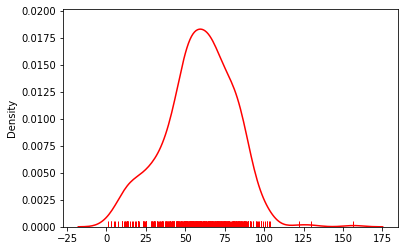

In [22]:
fig, ax = plt.subplots()
sns.distplot(data_2017_01.loc[data_2017_01['TRANS CAC DESC 1'] == 'Vehicle Fuel']['BILLING GROSS AMT'].values, rug=True, hist=False, ax=ax, color ='r')
plt.show()

In [ ]:

sns.distplot(data_2017_01.loc[data_2017_01['TRANS CAC DESC 1'] == 'Supplies & Sev Mic']['BILLING GROSS AMT'].values, rug=True, hist=False, ax=ax)

In [120]:
for i in range(2015,2019):
    for j in range(1,13):
        print('{}_{}_purchases.xls'.format(i,str(j).zfill(2)))

2015_01_purchases.xls
2015_02_purchases.xls
2015_03_purchases.xls
2015_04_purchases.xls
2015_05_purchases.xls
2015_06_purchases.xls
2015_07_purchases.xls
2015_08_purchases.xls
2015_09_purchases.xls
2015_10_purchases.xls
2015_11_purchases.xls
2015_12_purchases.xls
2016_01_purchases.xls
2016_02_purchases.xls
2016_03_purchases.xls
2016_04_purchases.xls
2016_05_purchases.xls
2016_06_purchases.xls
2016_07_purchases.xls
2016_08_purchases.xls
2016_09_purchases.xls
2016_10_purchases.xls
2016_11_purchases.xls
2016_12_purchases.xls
2017_01_purchases.xls
2017_02_purchases.xls
2017_03_purchases.xls
2017_04_purchases.xls
2017_05_purchases.xls
2017_06_purchases.xls
2017_07_purchases.xls
2017_08_purchases.xls
2017_09_purchases.xls
2017_10_purchases.xls
2017_11_purchases.xls
2017_12_purchases.xls
2018_01_purchases.xls
2018_02_purchases.xls
2018_03_purchases.xls
2018_04_purchases.xls
2018_05_purchases.xls
2018_06_purchases.xls
2018_07_purchases.xls
2018_08_purchases.xls
2018_09_purchases.xls
2018_10_pu